## Identifying Artist from Art


**Grupo:** Giulio Lelis, Gustavo Zille e Vinícius França

O objetivo principal deste trabalho é construir uma rede neural capaz de classificar o artista responsável por uma determianda obra de arte (pintura).

Para isso, utilizaremos o conjunto de dados [**Best Artworks of All Time**](https://www.kaggle.com/ikarus777/best-artworks-of-all-time).

In [1]:
import pandas as pd

from identifying_artist_from_art import *

**Primeiro passo: análise e pré-processamento de dados**

Analisando a quantidade de amostras (pinturas) por classe (artista) é possível perceber que o conjunto de dados não possui uma distribuição balanceada.

In [2]:
artists_df = pd.read_csv('archive/artists.csv')
artists_df = artists_df.sort_values(by='paintings', ignore_index=True, ascending=False).filter(items=['name', 'paintings'])

artists_df[:10]

,name,paintings
0,Vincent van Gogh,877
1,Edgar Degas,702
2,Pablo Picasso,439
3,Pierre-Auguste Renoir,336
4,Albrecht Dürer,328
5,Paul Gauguin,311
6,Francisco Goya,291
7,Rembrandt,262
8,Alfred Sisley,259
9,Titian,255


Após alguns testes utilizando o conjunto inteiro das amostras foi percebido que essa má distribuição impactava negativamente no ajuste da rede neural, e consequentemente na taxa de acurácia dos resultados. Portanto, decidimos utilizar somente as duas classes (artistas) que possuem a maior quantidade de amostras nesse conjunto de dados. Dessa forma também, o objetivo da rede se resume em uma classificação binária.

In [3]:
useful_artists = artists_df[:2]['name'].str.replace(' ', '_').values.tolist()

print(f'Selected artists to binary classification: {useful_artists}')

Selected artists to binary classification: ['Vincent_van_Gogh', 'Edgar_Degas']


**Segundo passo: leitura e armazenamento dos dados**

Mesmo filtrando as classes com o maior número de amostras, o volume delas no conjunto ainda pode causar um **underfitting** no processo de aprendizado da rede. Portanto, foram aplicadas algumas estratégias de **data augmentation** para aumentar a quantidade de dados, isto significa criar novas imagens a partir das imagens já existentes, alterando a sua rotação, escala e posicionamento randomicamente.

```python
rotation_range = 45
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
zoom_range = 0.2
horizontal_flip = True
vertical_flip = True
```

In [4]:
params = {
    'directory': 'archive/images/images',
    'target_size': (256, 256),
    'classes': useful_artists,
    'class_mode': 'binary',
    'batch_size': 32
}

train_gen, validation_gen = get_generators_from_dir(params, rescale=True, enable_augmentation=True)

Found 1264 images belonging to 2 classes.
Found 315 images belonging to 2 classes.


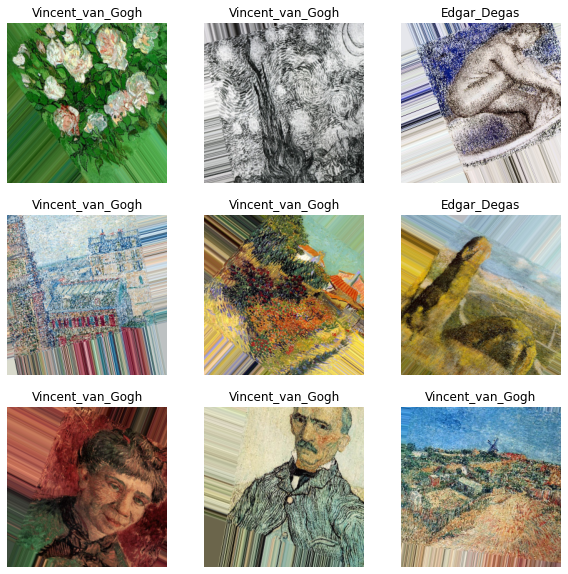

In [5]:
show_gen_samples(train_gen, useful_artists)

**Terceiro passo: construção e processamento do modelo da rede**

As imagens foram convertidas para matrizes RGB/pixel e distribuídas em **batches** de tamanho 32. Portanto, foi construída uma rede neural de três camadas convolucionais, para lidar com o processamento e a generalização em cima das imagens, e uma camada densa final (_fully connected_) para lidar com a especialização da saída da rede.

In [6]:
simple_binary_model = build_and_compile_binary_model()

In [7]:
history = run_model(simple_binary_model, train_gen, validation_gen, epochs=10)

Epoch 1/10
40/40 [==============================] - 60s 1s/step - loss: 1.2550 - accuracy: 0.5121 - val_loss: 0.6425 - val_accuracy: 0.5556
Epoch 2/10
40/40 [==============================] - 58s 1s/step - loss: 0.5817 - accuracy: 0.6535 - val_loss: 0.5252 - val_accuracy: 0.7016
Epoch 3/10
40/40 [==============================] - 58s 1s/step - loss: 0.5110 - accuracy: 0.7657 - val_loss: 0.4948 - val_accuracy: 0.7524
Epoch 4/10
40/40 [==============================] - 58s 1s/step - loss: 0.5005 - accuracy: 0.7341 - val_loss: 0.4957 - val_accuracy: 0.7683
Epoch 5/10
40/40 [==============================] - 58s 1s/step - loss: 0.4813 - accuracy: 0.7844 - val_loss: 0.5131 - val_accuracy: 0.7778
Epoch 6/10
40/40 [==============================] - 59s 1s/step - loss: 0.4361 - accuracy: 0.8262 - val_loss: 0.4864 - val_accuracy: 0.7746
Epoch 7/10
40/40 [==============================] - 60s 1s/step - loss: 0.4316 - accuracy: 0.8140 - val_loss: 0.4424 - val_accuracy: 0.8095
Epoch 8/10
40/40 [==

In [8]:
simple_binary_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0

Devido a alta quantidade de parâmetros da rede, muito por conta do tamanho das entradas (imagens), foi introduzida uma camada de **dropout** após os processos convolucionais.

**Quarto passo: amostragem e análise dos resultados**

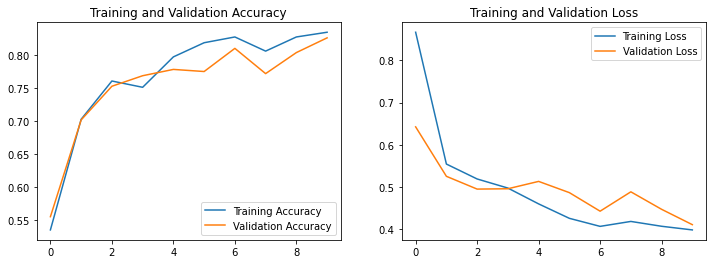

In [9]:
show_model_process_results(history, epochs=10)

Para a classificação binária entre os artistas com o maior acervo de pinturas dentro do **dataset** escolhido, a RNC (Rede Neural Convolucional) conseguiu se ajustar bem com apenas 10 épocas e apresentar uma taxa de acurácia considerável.

**Quinto passo: predizendo um dado a partir do modelo treinado**

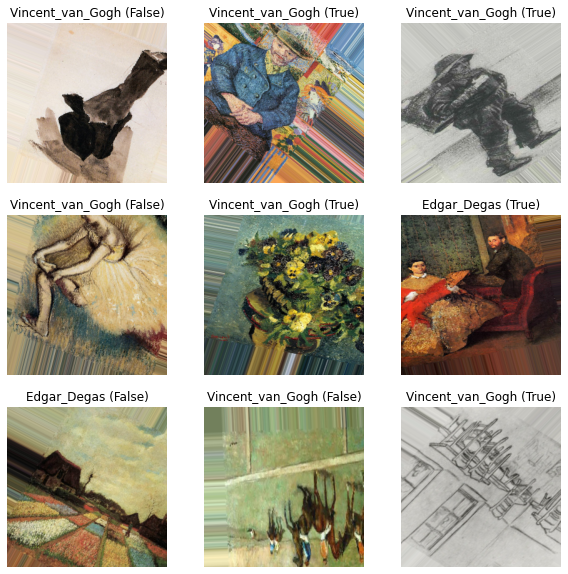

In [17]:
image_batch, label_batch = validation_gen.next()
predictions = simple_binary_model.predict_generator(image_batch)
predictions = tf.where(predictions < 0.5, 0, 1).numpy().flatten()

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.imshow(image_batch[i])
    plt.title("{} ({})".format(useful_artists[predictions[i]], predictions[i] == label_batch[i]))
    plt.axis("off")